# Demand Forecasting — Modeling & Evaluation

This notebook focuses on time-aware data splitting, baseline modeling,
and evaluation of forecasting performance.


Import Library

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pathlib import Path
import json


Load Feature-Engineered Data

In [2]:
DATA_DIR = Path("../data/processed")

train_fe = pd.read_csv(DATA_DIR / "train_fe.csv", parse_dates=["date"])
test_fe  = pd.read_csv(DATA_DIR / "test_fe.csv", parse_dates=["date"])

print(train_fe.shape)
print(test_fe.shape)


(899000, 17)
(500, 17)


Time-based Split

In [3]:
TARGET = "sales"

FEATURES = [
    "store",
    "item",
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
    "lag_7",
    "lag_14",
    "lag_28",
    "rolling_mean_7",
    "rolling_mean_14",
    "rolling_mean_28"
]


In [4]:
split_date = "2017-01-01"

train_df = train_fe[train_fe['date'] < split_date]
valid_df = train_fe[train_fe['date'] >= split_date]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_valid = valid_df[FEATURES]
y_valid = valid_df[TARGET]


BASELINE MODEL

Install & Import

In [5]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


Dataset ke LightGBM Format

In [59]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

Parameter Baseline

In [7]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
    "verbosity": -1
}


Fungsi SMAPE

In [8]:
import numpy as np

def custom_smape(y_true, y_pred):
    
    # Menghindari pembagian dengan nol
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    
    # Dikali 200 karena denominator tidak dibagi 2 di rumus atas
    smape_val = 200 * np.mean(diff)
    
    # Return format: "nama metric", nilai, is_higher_better
    return 'smape', smape_val, False

Training

In [10]:
# 1. Masukkan jumlah round ke params (agar rapi)
params['n_estimators'] = 2000 

# 2. Inisialisasi Model
model = lgb.LGBMRegressor(**params)

# 3. Fit dengan parameter yang benar untuk LGBMRegressor
model.fit(
    X_train, y_train,  # <-- Masukkan X dan y terpisah di sini
    eval_set=[(X_train, y_train), (X_valid, y_valid)], # Ganti valid_sets jadi eval_set
    eval_names=["train", "valid"], # Ganti valid_names jadi eval_names
    eval_metric=custom_smape, # Fungsi custom metric kamu
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 10.0608	train's smape: 18.5044	valid's rmse: 11.5076	valid's smape: 16.9219
[100]	train's rmse: 7.81022	train's smape: 13.9023	valid's rmse: 8.62372	valid's smape: 12.9479
[150]	train's rmse: 7.5414	train's smape: 13.2845	valid's rmse: 8.23675	valid's smape: 12.4293
[200]	train's rmse: 7.4616	train's smape: 13.1331	valid's rmse: 8.12107	valid's smape: 12.2871
[250]	train's rmse: 7.42074	train's smape: 13.0734	valid's rmse: 8.06252	valid's smape: 12.2245
[300]	train's rmse: 7.39409	train's smape: 13.0397	valid's rmse: 8.02814	valid's smape: 12.1903
[350]	train's rmse: 7.37384	train's smape: 13.0144	valid's rmse: 8.00428	valid's smape: 12.166
[400]	train's rmse: 7.35736	train's smape: 12.9968	valid's rmse: 7.98577	valid's smape: 12.1492
[450]	train's rmse: 7.34308	train's smape: 12.981	valid's rmse: 7.97118	valid's smape: 12.1349
[500]	train's rmse: 7.33133	train's smape: 12.9676	valid's rmse: 7.95924	valid's

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,2000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Training dengan Log-Transformation

In [11]:
# 1. Definisi Custom Metric KHUSUS untuk Log Target
def custom_smape_log_version(y_true, y_pred):
    # Kembalikan prediksi & truth ke skala asli (expm1)
    y_true_real = np.expm1(y_true)
    y_pred_real = np.expm1(y_pred)
    
    # Hitung SMAPE
    denominator = (np.abs(y_true_real) + np.abs(y_pred_real))
    diff = np.abs(y_true_real - y_pred_real) / denominator
    diff[denominator == 0] = 0.0
    
    smape_val = 200 * np.mean(diff)
    return 'smape', smape_val, False


In [12]:
# 2. Transformasi Target ke Log
# Asumsi: X_train, y_train, X_val, y_val sudah ada dari kode sebelumnya
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_valid)

In [13]:
# 4. Training
model_log = lgb.LGBMRegressor(**params)

model_log.fit(
    X_train, 
    y_train_log,  # <-- INPUT TARGET LOG
    eval_set=[(X_train, y_train_log), (X_valid, y_val_log)], # <-- EVAL SET JUGA LOG
    eval_names=["train", "valid"],
    eval_metric=custom_smape_log_version, # <-- FUNGSI EVALUASI BARU
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 0.215445	train's smape: 17.0217	valid's rmse: 0.211643	valid's smape: 17.0594
[100]	train's rmse: 0.17309	train's smape: 13.5784	valid's rmse: 0.1643	valid's smape: 12.9704
[150]	train's rmse: 0.168406	train's smape: 13.2108	valid's rmse: 0.158627	valid's smape: 12.4558
[200]	train's rmse: 0.167208	train's smape: 13.1145	valid's rmse: 0.157185	valid's smape: 12.3213
[250]	train's rmse: 0.166584	train's smape: 13.0632	valid's rmse: 0.1565	valid's smape: 12.2571
[300]	train's rmse: 0.166186	train's smape: 13.0302	valid's rmse: 0.156122	valid's smape: 12.221
[350]	train's rmse: 0.165874	train's smape: 13.0055	valid's rmse: 0.155852	valid's smape: 12.1954
[400]	train's rmse: 0.165617	train's smape: 12.9851	valid's rmse: 0.155657	valid's smape: 12.1774
[450]	train's rmse: 0.16539	train's smape: 12.9674	valid's rmse: 0.155495	valid's smape: 12.1627
[500]	train's rmse: 0.165186	train's smape: 12.9522	valid's rmse:

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,2000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [14]:

# 5. Cek Hasil Akhir (RMSE di skala asli)
from sklearn.metrics import mean_squared_error

pred_log = model_log.predict(X_valid)
pred_original = np.expm1(pred_log) # Kembalikan ke angka asli

final_rmse = np.sqrt(mean_squared_error(y_valid, pred_original))
print(f"\nRMSE Akhir (Skala Asli): {final_rmse}")


RMSE Akhir (Skala Asli): 7.941461186055965


XGBoost

In [17]:
import xgboost as xgb

# 1. Setup Data (Gunakan data TANPA log, karena hasil terbaikmu tadi tanpa log)
# Pastikan X_train, y_train, X_val, y_val sudah ready (skala asli)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse', # XGBoost bawaan tidak punya SMAPE, kita pantau RMSE dulu
    'n_estimators': 2000,
    'learning_rate': 0.03,
    'max_depth': 8,          # Sedikit lebih dalam dari LGBM biasanya
    'subsample': 0.7,        # Ambil 70% data tiap tree (mencegah overfit)
    'colsample_bytree': 0.7, # Ambil 70% fitur tiap tree
    'random_state': 42,
    'n_jobs': -1,           # Gunakan semua core CPU
    'early_stopping_rounds': 50
}



In [18]:

model_xgb = xgb.XGBRegressor(**xgb_params)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100,
    
)

[0]	validation_0-rmse:27.11329	validation_1-rmse:31.62694
[100]	validation_0-rmse:7.54757	validation_1-rmse:8.30067
[200]	validation_0-rmse:7.28946	validation_1-rmse:7.98528
[300]	validation_0-rmse:7.22037	validation_1-rmse:7.94783
[400]	validation_0-rmse:7.16890	validation_1-rmse:7.93167
[500]	validation_0-rmse:7.12581	validation_1-rmse:7.92369
[600]	validation_0-rmse:7.08755	validation_1-rmse:7.91986
[700]	validation_0-rmse:7.05442	validation_1-rmse:7.91783
[794]	validation_0-rmse:7.02503	validation_1-rmse:7.91756


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'rmse'


In [19]:

# 2. Prediksi
pred_xgb = model_xgb.predict(X_valid)

# 3. Cek Score XGBoost Sendirian
rmse_xgb = np.sqrt(mean_squared_error(y_valid, pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 7.916882267743318


In [20]:
pred_xgb = model_xgb.predict(X_valid)

# Fungsi hitung manual (biar gak error)
def manual_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

smape_xgb = manual_smape(y_valid, pred_xgb)
print(f"XGBoost SMAPE: {smape_xgb}")

XGBoost SMAPE: 12.054209907679027


ENSEMBLE (GABUNGAN) 

In [23]:
pred_lgbm = model.predict(X_valid) 


# 2. Coba Gabungan Rata (50:50)
ensemble_pred = (0.5 * pred_lgbm) + (0.5 * pred_xgb)

# 3. Coba Gabungan Berbobot (Karena LightGBM sedikit lebih bagus, kita kasih bobot lebih)
# Misal: 60% LightGBM + 40% XGBoost
weighted_pred = (0.7 * pred_lgbm) + (0.3 * pred_xgb)

# 4. Hitung SMAPE
smape_50_50 = manual_smape(y_valid, ensemble_pred)
smape_weighted = manual_smape(y_valid, weighted_pred)

print(f"LightGBM Sendiri : 12.03") 
print(f"XGBoost Sendiri  : {12.05}")
print("-------------------------------")
print(f"Gabungan 50:50   : {smape_50_50:.5f}")
print(f"Gabungan 70:30   : {smape_weighted:.5f}")

LightGBM Sendiri : 12.03
XGBoost Sendiri  : 12.05
-------------------------------
Gabungan 50:50   : 12.03432
Gabungan 70:30   : 12.03257


CatBoost

In [27]:
!pip install catboost
from catboost import CatBoostRegressor


cat_features = ['store', 'item', 'month', 'dayofweek', 'is_weekend']

# 2. Setup Params
cb_params = {
    'iterations': 1500,
    'learning_rate': 0.03,
    'depth': 8,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'cat_features': cat_features 
}


   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 1.0/102.5 MB 8.4 MB/s eta 0:00:13
   - -------------------------------------- 3.4/102.5 MB 10.6 MB/s eta 0:00:10
   -- ------------------------------------- 6.0/102.5 MB 11.5 MB/s eta 0:00:09
   --- ------------------------------------ 8.4/102.5 MB 11.6 MB/s eta 0:00:09
   ---- ----------------------------------- 11.0/102.5 MB 11.5 MB/s eta 0:00:08
   ----- ---------------------------------- 13.6/102.5 MB 11.6 MB/s eta 0:00:08
   ------ --------------------------------- 16.0/102.5 MB 11.6 MB/s eta 0:00:08
   ------ --------------------------------- 17.8/102.5 MB 11.1 MB/s eta 0:00:08
   ------- -------------------------------- 20.2/102.5 MB 11.1 MB/s eta 0:00:08
   -------- ------------------------------- 22.5/102.5 MB 11.2 MB/s eta 0:00:08
   --------- ------------------------------ 25.2/102.5 MB 11.3 MB/s eta 0:00:07
   ---------- ----------------------------- 27.5/102.5

In [28]:
model_cat = CatBoostRegressor(**cb_params)

# 3. Fit Model
model_cat.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

0:	learn: 27.1402152	test: 31.6729692	best: 31.6729692 (0)	total: 771ms	remaining: 19m 15s
100:	learn: 7.8271298	test: 8.6811720	best: 8.6811720 (100)	total: 1m	remaining: 13m 54s
200:	learn: 7.4703835	test: 8.1238843	best: 8.1238843 (200)	total: 1m 48s	remaining: 11m 38s
300:	learn: 7.4077657	test: 8.0331373	best: 8.0331373 (300)	total: 2m 37s	remaining: 10m 27s
400:	learn: 7.3716342	test: 7.9902273	best: 7.9902273 (400)	total: 3m 26s	remaining: 9m 25s
500:	learn: 7.3433218	test: 7.9599679	best: 7.9599679 (500)	total: 4m 18s	remaining: 8m 35s
600:	learn: 7.3197353	test: 7.9371438	best: 7.9371438 (600)	total: 5m 12s	remaining: 7m 47s
700:	learn: 7.2997393	test: 7.9200733	best: 7.9200733 (700)	total: 6m 6s	remaining: 6m 57s
800:	learn: 7.2819705	test: 7.9062128	best: 7.9062128 (800)	total: 6m 59s	remaining: 6m 6s
900:	learn: 7.2665232	test: 7.8953408	best: 7.8953408 (900)	total: 7m 53s	remaining: 5m 14s
1000:	learn: 7.2525185	test: 7.8870223	best: 7.8870223 (1000)	total: 8m 47s	remainin

In [29]:
# 4. Prediksi & Cek SMAPE
pred_cat = model_cat.predict(X_valid)
smape_cat = manual_smape(y_valid, pred_cat)
print(f"CatBoost SMAPE: {smape_cat}")

CatBoost SMAPE: 11.953905166715016


In [45]:
pred_ensemble = (0.8 * pred_cat) + (0.2 * pred_lgbm) 

# Evaluasi Final
smape_cat = manual_smape(y_valid, pred_cat)
smape_ens = manual_smape(y_valid, pred_ensemble)

print("=== LEADERBOARD SEMENTARA ===")
print(f"1. CatBoost (New King) : {smape_cat:.5f}")
print(f"2. LightGBM            : {manual_smape(y_valid, pred_lgbm):.5f}")
print(f"3. XGBoost             : {manual_smape(y_valid, pred_xgb):.5f}")
print("-" * 35)
print(f"ENSEMBLE FINAL      : {smape_ens:.5f}")

=== LEADERBOARD SEMENTARA ===
1. CatBoost (New King) : 11.95391
2. LightGBM            : 12.03663
3. XGBoost             : 12.05421
-----------------------------------
ENSEMBLE FINAL      : 11.95376


In [50]:
import pandas as pd
import numpy as np
import os

# 1. Load Data Test
# Pastikan path filenya benar
test_df = pd.read_csv('../data/processed/test_fe.csv')
test_ids = test_df['id']

# 2. Siapkan X_test
# Drop kolom yang tidak dipakai (sama seperti saat training)
X_test = test_df.drop(['id', 'sales', 'date'], axis=1, errors='ignore')

# PENTING: Pastikan urutan kolom sesuai dengan saat training
# Ambil daftar kolom dari X_train (asumsi variabel X_train masih ada)
X_test = X_test[X_train.columns]

# 3. Prediksi dengan KEDUA Model
print("1/2 Memprediksi dengan CatBoost...")
pred_test_cat = model_cat.predict(X_test)

print("2/2 Memprediksi dengan LightGBM...")
pred_test_lgbm = model.predict(X_test)

# 4. TERAPKAN RUMUS ENSEMBLE (0.8 : 0.2) 
final_pred_test = (0.8 * pred_test_cat) + (0.2 * pred_test_lgbm)

# 5. Buat Submission DataFrame
submission = pd.DataFrame({
    'id': test_ids.astype(int),
    'sales': final_pred_test
})

# Koreksi nilai negatif (penjualan tidak mungkin minus)
submission['sales'] = submission['sales'].clip(lower=0)

# 6. Simpan
filename = 'submission_ensemble_80cat_20lgb.csv'
output_folder = '../submissions'
os.makedirs(output_folder, exist_ok=True)
full_path = os.path.join(output_folder, filename)
submission.to_csv(full_path, index=False)


print(f"File tersimpan di: {os.path.abspath(full_path)}")


1/2 Memprediksi dengan CatBoost...
2/2 Memprediksi dengan LightGBM...
File tersimpan di: d:\AI_ML ENGINEER\demand-forecasting-mlops\submissions\submission_ensemble_80cat_20lgb.csv


Visualisasi & Feature Importance

In [55]:
import seaborn as sns

exp_dir = '../experiments'
os.makedirs(exp_dir, exist_ok=True)

# Set Style Visualisasi
sns.set(style="whitegrid")

print(f"Folder eksperimen siap di: {os.path.abspath(exp_dir)}")

Folder eksperimen siap di: d:\AI_ML ENGINEER\demand-forecasting-mlops\experiments


Grafik 1 - Learning Curves (Train vs Valid)

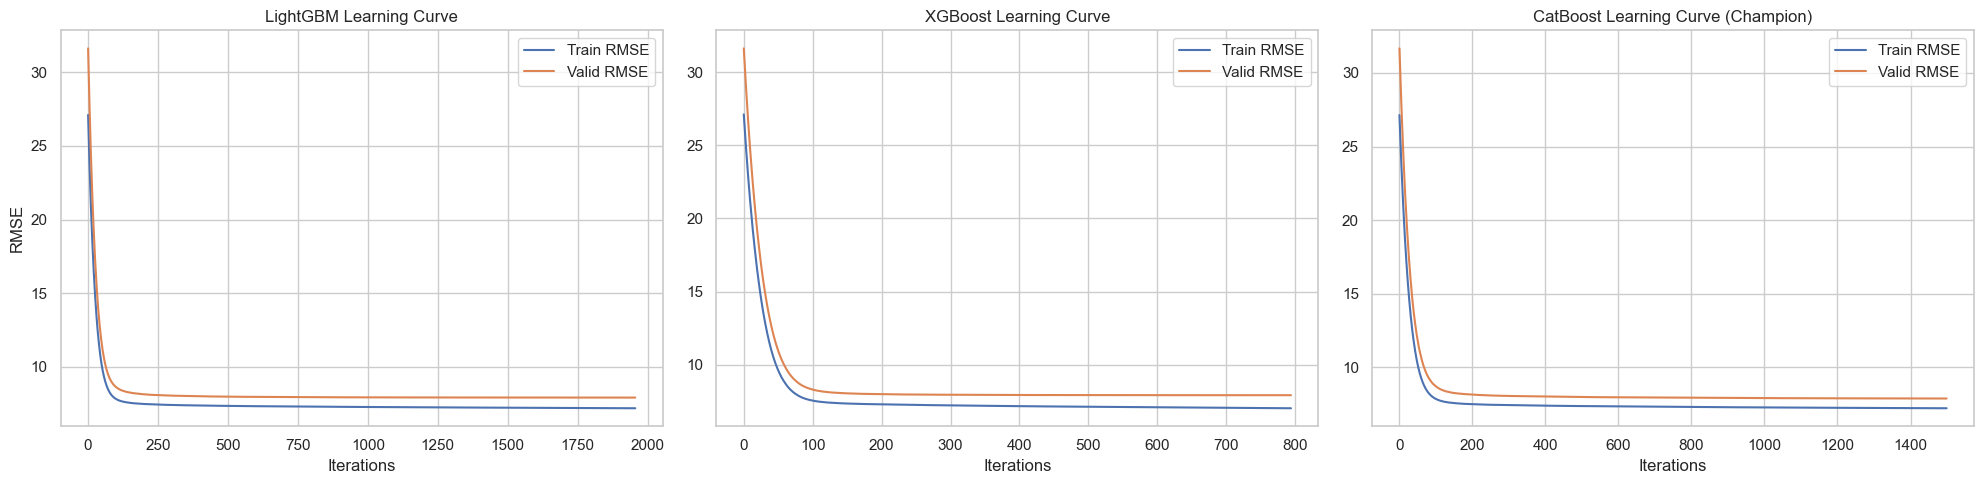

✅ Grafik tersimpan di: ../experiments/1_learning_curves_comparison.png


In [56]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# --- A. LightGBM ---
try:
    # LightGBM menyimpan history di .evals_result_
    lgb_res = model.evals_result_
    axes[0].plot(lgb_res['train']['rmse'], label='Train RMSE')
    axes[0].plot(lgb_res['valid']['rmse'], label='Valid RMSE')
    axes[0].set_title('LightGBM Learning Curve')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()
except Exception as e:
    axes[0].text(0.5, 0.5, f'History not found\n{str(e)}', ha='center')

# --- B. XGBoost ---
try:
    # XGBoost menyimpan history di .evals_result()
    xgb_res = model_xgb.evals_result()
    # XGBoost menamai setnya validation_0 (train) dan validation_1 (valid)
    axes[1].plot(xgb_res['validation_0']['rmse'], label='Train RMSE')
    axes[1].plot(xgb_res['validation_1']['rmse'], label='Valid RMSE')
    axes[1].set_title('XGBoost Learning Curve')
    axes[1].set_xlabel('Iterations')
    axes[1].legend()
except Exception as e:
    axes[1].text(0.5, 0.5, f'History not found\n{str(e)}', ha='center')

# --- C. CatBoost ---
try:
    # CatBoost menyimpan history di .get_evals_result()
    cat_res = model_cat.get_evals_result()
    axes[2].plot(cat_res['learn']['RMSE'], label='Train RMSE')
    
    # Deteksi nama key validasi (kadang 'validation', kadang 'test')
    val_key = 'validation' if 'validation' in cat_res else list(cat_res.keys())[-1]
    axes[2].plot(cat_res[val_key]['RMSE'], label='Valid RMSE')
    
    axes[2].set_title('CatBoost Learning Curve (Champion)')
    axes[2].set_xlabel('Iterations')
    axes[2].legend()
except Exception as e:
    axes[2].text(0.5, 0.5, f'History not found\n{str(e)}', ha='center')

plt.tight_layout()

# Simpan dan Tampilkan
save_path = f'{exp_dir}/1_learning_curves_comparison.png'
plt.savefig(save_path)
plt.show()
print(f"✅ Grafik tersimpan di: {save_path}")

Grafik 2 - Zoom In Prediksi (Actual vs Models)

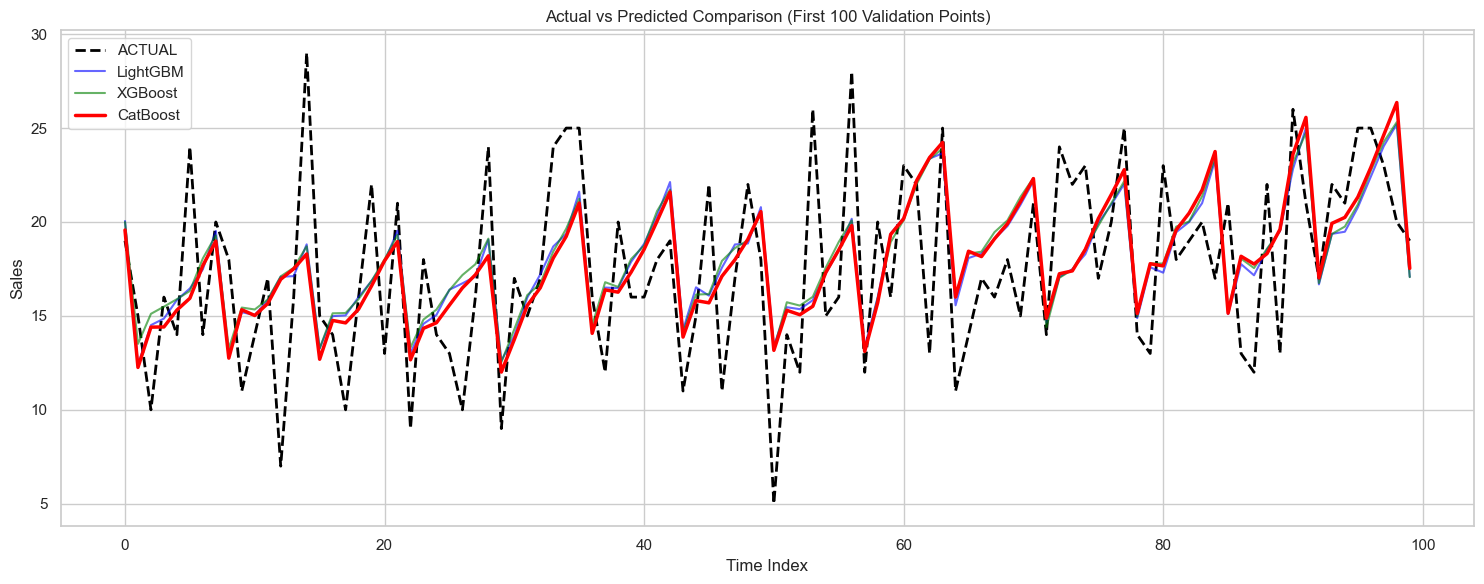

Grafik tersimpan di: ../experiments/2_model_vs_actual(100data).png


In [64]:

# Kita ambil sampel 100 data terakhir dari validation set
subset_len = 100
indices = range(subset_len)

plt.figure(figsize=(15, 6))

# 1. Plot Data Asli (Hitam Putus-putus)
plt.plot(indices, y_valid.iloc[:subset_len].values, label='ACTUAL', color='black', linewidth=2, linestyle='--')

# 2. Plot Model Predictions
# Pastikan variabel prediksi (pred_lgbm, dll) masih ada di memori
plt.plot(indices, pred_lgbm[:subset_len], label='LightGBM', alpha=0.6, color='blue')
plt.plot(indices, pred_xgb[:subset_len], label='XGBoost', alpha=0.6, color='green')
plt.plot(indices, pred_cat[:subset_len], label='CatBoost', linewidth=2.5, color='red') # Highlight Champion

plt.title(f'Actual vs Predicted Comparison (First {subset_len} Validation Points)')
plt.ylabel('Sales')
plt.xlabel('Time Index')
plt.legend()
plt.tight_layout()

# Simpan dan Tampilkan
save_path = f'{exp_dir}/2_model_vs_actual(100data).png'
plt.savefig(save_path)
plt.show()
print(f"Grafik tersimpan di: {save_path}")

full validation

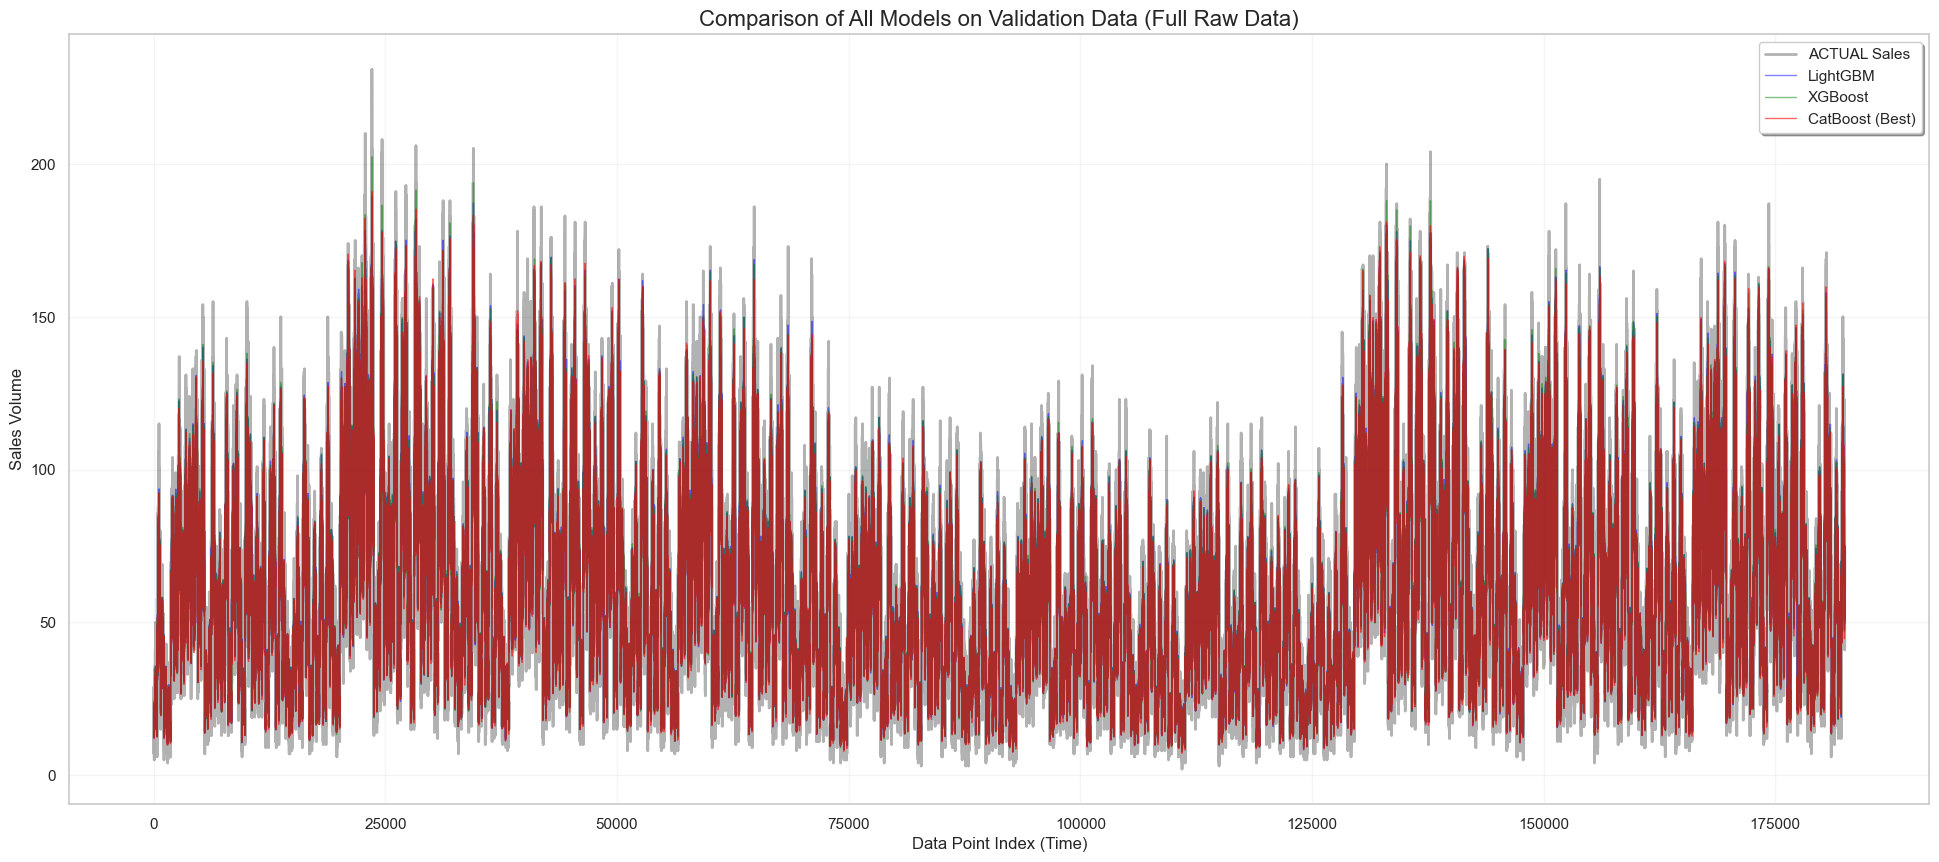

Grafik Raksasa tersimpan di: ../experiments/3_models_vs_actual_full.png


In [63]:
plt.figure(figsize=(24, 10)) # Ukuran kanvas ekstra besar

plt.plot(y_valid.reset_index(drop=True), label='ACTUAL Sales', color='black', alpha=0.3, linewidth=2)

# 2. Plot LightGBM - Warna Biru
plt.plot(pred_lgbm, label='LightGBM', color='blue', alpha=0.5, linewidth=1)

# 3. Plot XGBoost - Warna Hijau
plt.plot(pred_xgb, label='XGBoost', color='green', alpha=0.5, linewidth=1)

# 4. Plot CatBoost (Champion) - Warna Merah
plt.plot(pred_cat, label='CatBoost (Best)', color='red', alpha=0.6, linewidth=1)

# Dekorasi
plt.title('Comparison of All Models on Validation Data (Full Raw Data)', fontsize=16)
plt.ylabel('Sales Volume')
plt.xlabel('Data Point Index (Time)')
plt.legend(loc='upper right', frameon=True, framealpha=1, shadow=True)
plt.grid(True, alpha=0.2)

# Simpan supaya bisa di-zoom nanti di image viewer komputer
save_path = f'{exp_dir}/3_models_vs_actual_full.png'
plt.savefig(save_path, dpi=150) 
plt.show()

print(f"Grafik Raksasa tersimpan di: {save_path}")

Grafik 3 - Feature Importance

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8472\2470914156.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi_df.head(10), palette='viridis')


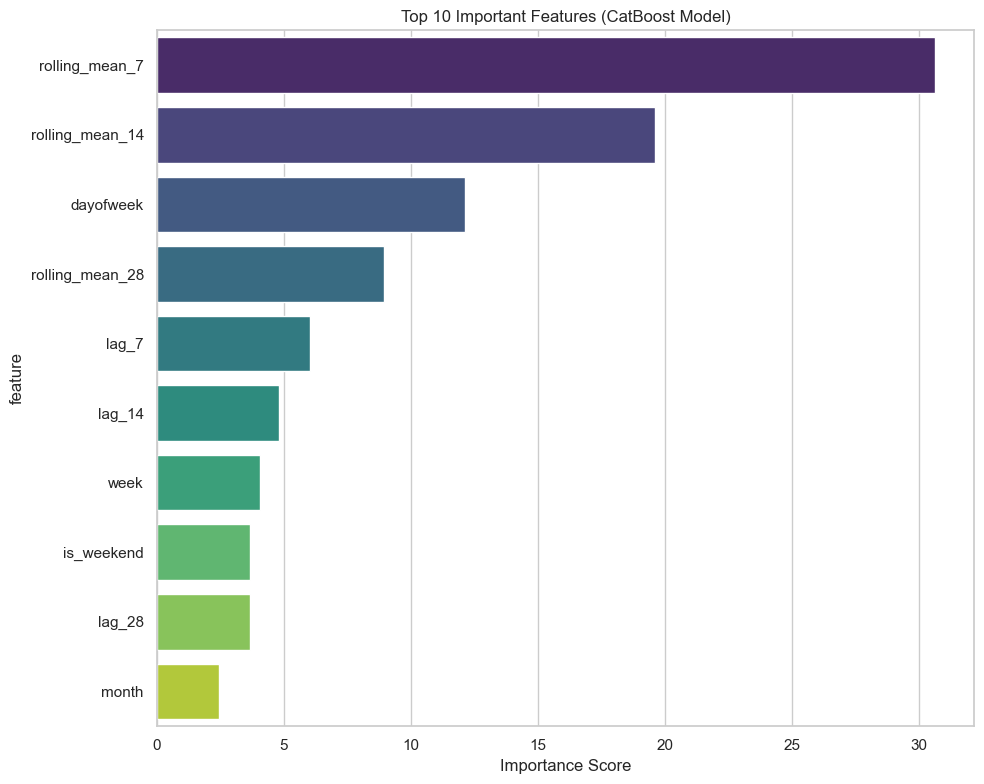

Grafik tersimpan di: ../experiments/4_catboost_feature_importance.png


In [65]:
# Ambil importance dari model CatBoost
fi = model_cat.get_feature_importance()
fi_df = pd.DataFrame({'feature': X_train.columns, 'importance': fi}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=fi_df.head(10), palette='viridis')

plt.title('Top 10 Important Features (CatBoost Model)')
plt.xlabel('Importance Score')
plt.tight_layout()

# Simpan dan Tampilkan
save_path = f'{exp_dir}/4_catboost_feature_importance.png'
plt.savefig(save_path)
plt.show()
print(f"Grafik tersimpan di: {save_path}")

"The feature importance analysis indicates that short-term trend aggregators are the primary drivers of the model's predictions. The 7-day and 14-day rolling means (rolling_mean_7, rolling_mean_14) dominate the importance scores, suggesting that the average sales volume over the past one to two weeks provides the strongest signal for future demand.

Weekly seasonality is also critical, with dayofweek ranking as the third most influential feature. This confirms that sales behavior is heavily dependent on the specific day (e.g., weekends vs. weekdays), independent of the general trend.

Notably, rolling mean features consistently outperform lag features across all time windows (e.g., rolling_mean_7 significantly outranks lag_7). This implies that the model relies more on stable trends (averages) rather than volatile single-day historical data points. Broader calendar features like week and month show lower contribution, further confirming that the sales dynamics are highly sensitive to recent history rather than long-term seasonal shifts."

In [67]:
import os
import joblib 

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

print(f"Menyimpan model ke folder: {os.path.abspath(model_dir)} ...")

# CatBoost punya format save sendiri yang sangat efisien
cat_path = os.path.join(model_dir, 'catboost_champion_smape_1195.cbm')
model_cat.save_model(cat_path)
print(f"CatBoost tersimpan: {cat_path}")


lgb_path = os.path.join(model_dir, 'lgbm_sub_champion.pkl')
joblib.dump(model, lgb_path)
print(f"LightGBM tersimpan: {lgb_path}")

# Jika kamu mau simpan XGBoost juga:
xgb_path = os.path.join(model_dir, 'xgboost_support.json')
model_xgb.save_model(xgb_path)
print(f"XGBoost tersimpan: {xgb_path}")

Menyimpan model ke folder: d:\AI_ML ENGINEER\demand-forecasting-mlops\models ...
CatBoost tersimpan: ../models\catboost_champion_smape_1195.cbm
LightGBM tersimpan: ../models\lgbm_sub_champion.pkl
XGBoost tersimpan: ../models\xgboost_support.json
